In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(r"archive (9)\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train", 
                                                    shuffle=True, 
                                                    image_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                    batch_size = BATCH_SIZE
                                                   )

Found 31482 files belonging to 17 classes.


In [4]:
class_names = dataset.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot']


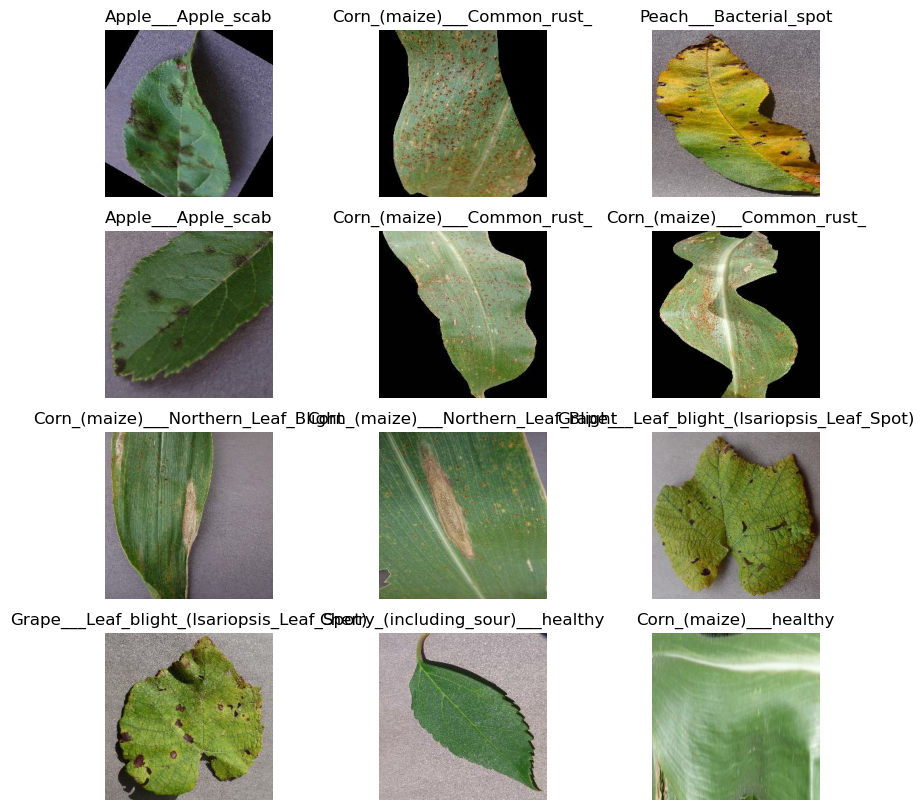

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
len(dataset)

984

In [7]:
train_size = 0.8
train_data = int(len(dataset)*train_size)

In [8]:
train_ds = dataset.take(train_data) 
len(train_ds)

787

In [9]:
test_ds = dataset.skip(train_data)
len(test_ds)

197

In [10]:
val_size = 0.1
val_data = int(len(dataset) * val_size)

In [11]:
val_ds = test_ds.take(val_data)
len(val_ds)

98

In [12]:
test_ds = test_ds.skip(10)
len(test_ds)

187

In [13]:
def get_dataset_partitions(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [15]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

787
98
99


In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 17
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'), 
])
model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [21]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [22]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics= ['accuracy']
)

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
]

# Train the model
history = model.fit(
    train_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=1,  # Set verbose to a non-zero value to see training progress
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10


787/787 [==============================] - 2028s 2s/step - loss: 1.3718 - accuracy: 0.5409 - val_loss: 0.8490 - val_accuracy: 0.7267 - lr: 0.0010
Epoch 2/10
787/787 [==============================] - 1419s 2s/step - loss: 0.4527 - accuracy: 0.8455 - val_loss: 0.4811 - val_accuracy: 0.8358 - lr: 0.0010
Epoch 3/10
787/787 [==============================] - 1502s 2s/step - loss: 0.2939 - accuracy: 0.8995 - val_loss: 0.3104 - val_accuracy: 0.8871 - lr: 0.0010
Epoch 4/10
787/787 [==============================] - 1421s 2s/step - loss: 0.2404 - accuracy: 0.9170 - val_loss: 0.2323 - val_accuracy: 0.9254 - lr: 0.0010
Epoch 5/10
787/787 [==============================] - 1410s 2s/step - loss: 0.2091 - accuracy: 0.9285 - val_loss: 0.7163 - val_accuracy: 0.7787 - lr: 0.0010
Epoch 6/10
787/787 [==============================] - 1432s 2s/step - loss: 0.1793 - accuracy: 0.9390 - val_loss: 0.2384 - val_accuracy: 0.9196 - lr: 0.0010
Epoch 7/10
787/787 [==============================] - 13

In [58]:
scores = model.evaluate(test_ds)
scores

99/99 [==============================] - 30s 303ms/step - loss: 0.1624 - accuracy: 0.9460


[0.16241680085659027, 0.9460227489471436]

In [59]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 787}

In [60]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

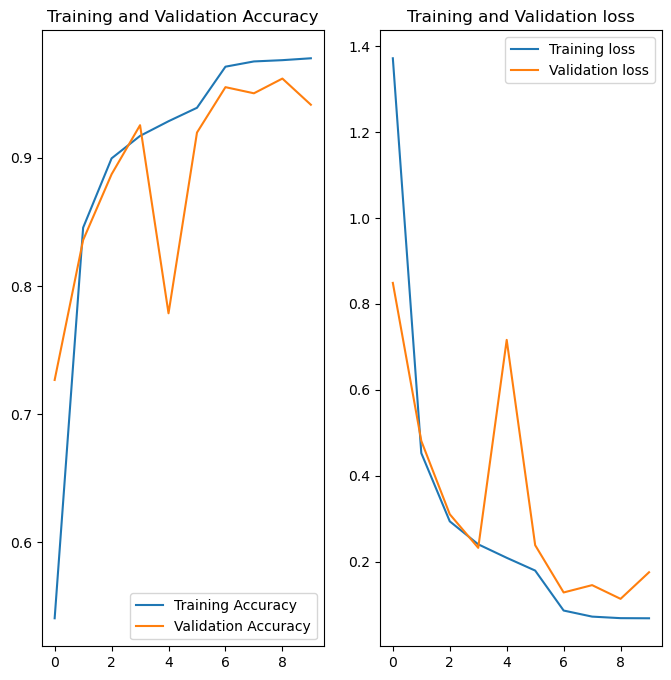

In [62]:
import matplotlib.pyplot as plt

# Ensure all datasets have the same length
min_length = min(len(acc), len(val_acc), len(loss), len(val_loss))
acc = acc[:min_length]
val_acc = val_acc[:min_length]
loss = loss[:min_length]
val_loss = val_loss[:min_length]

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(min_length), acc, label='Training Accuracy')
plt.plot(range(min_length), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(min_length), loss, label='Training loss')
plt.plot(range(min_length), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

plt.show()


first image to predict
actual label: Peach___Bacterial_spot
1/1 [==============================] - 0s 372ms/step
predicted label: Peach___Bacterial_spot


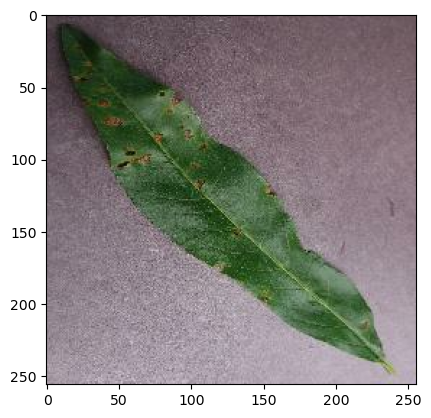

In [64]:
import numpy as np
class_names = dataset.class_names
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [65]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 72ms/step


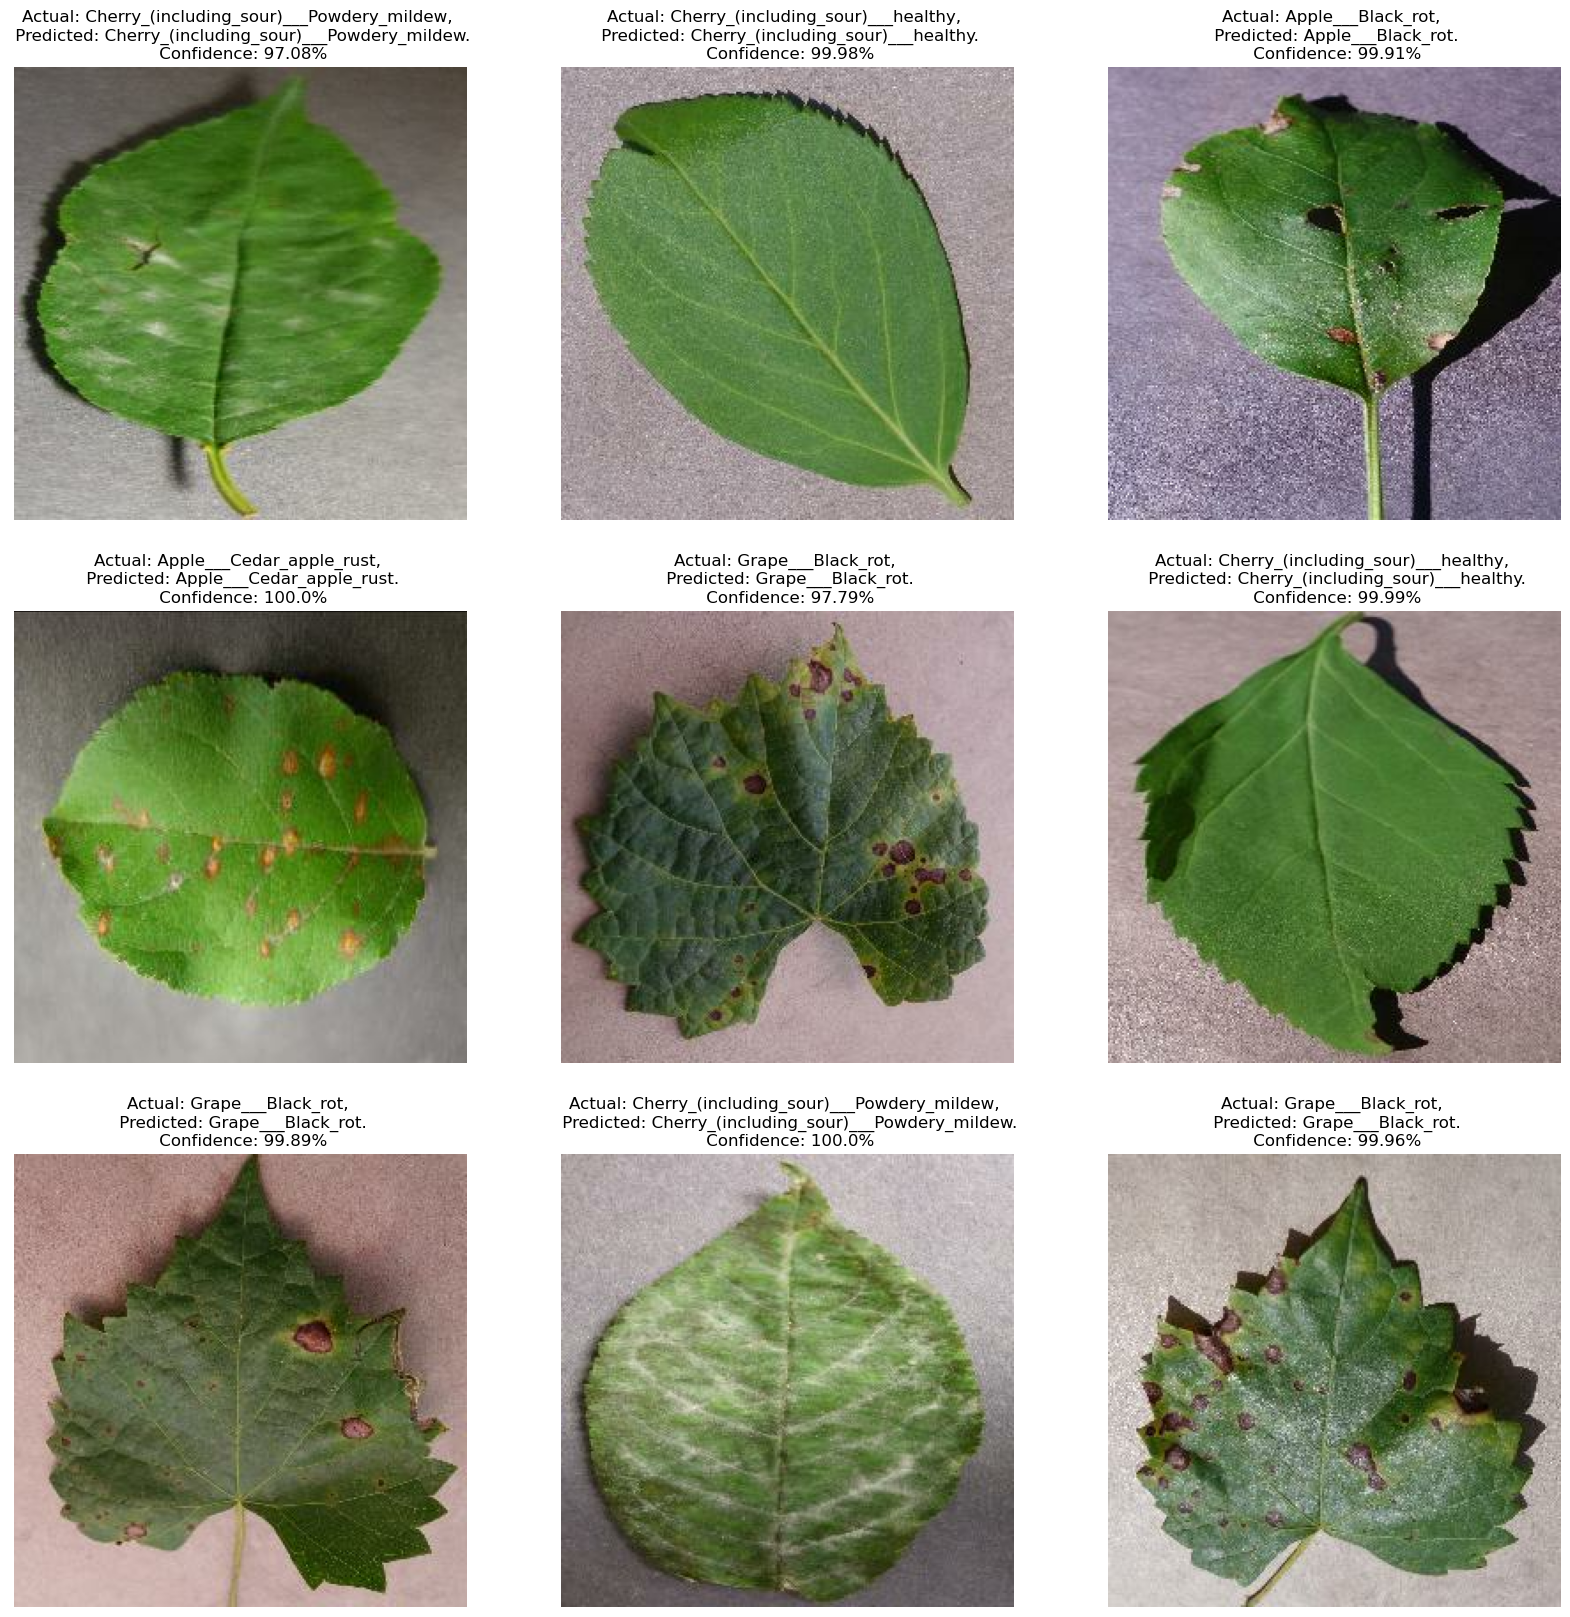

In [66]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [67]:
# Obtain the labels and predictions for the validation data.
labels = []
predictions = []
for x,y in val_ds:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

1/1 [==============================] - 0s 349ms/step


In [68]:
import itertools
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [69]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [70]:
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Train Accuracy  : 97.76 %
Test Accuracy   : 94.13 %
Precision Score : 94.13 %
Recall Score    : 94.13 %


In [71]:
# pred=model.predict(dataset)
# final_predict = np.argmax(pred,axis=1)
# true_data=class_names
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve,roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
f1 = f1_score(labels, predictions, average='macro')
print("F1 Score:", f1)
print(classification_report(labels, predictions, target_names=class_names))

F1 Score: 0.9412702900667483
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.94      0.92      0.93       208
                                 Apple___Black_rot       0.85      0.99      0.91       197
                          Apple___Cedar_apple_rust       0.99      0.94      0.97       181
                                   Apple___healthy       0.85      0.92      0.89       202
                               Blueberry___healthy       0.99      0.86      0.92       195
          Cherry_(including_sour)___Powdery_mildew       0.92      0.98      0.95       163
                 Cherry_(including_sour)___healthy       0.99      0.98      0.99       188
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.71      0.82       176
                       Corn_(maize)___Common_rust_       0.98      0.99      0.99       192
               Corn_(maize)___Northern_Leaf_Blight

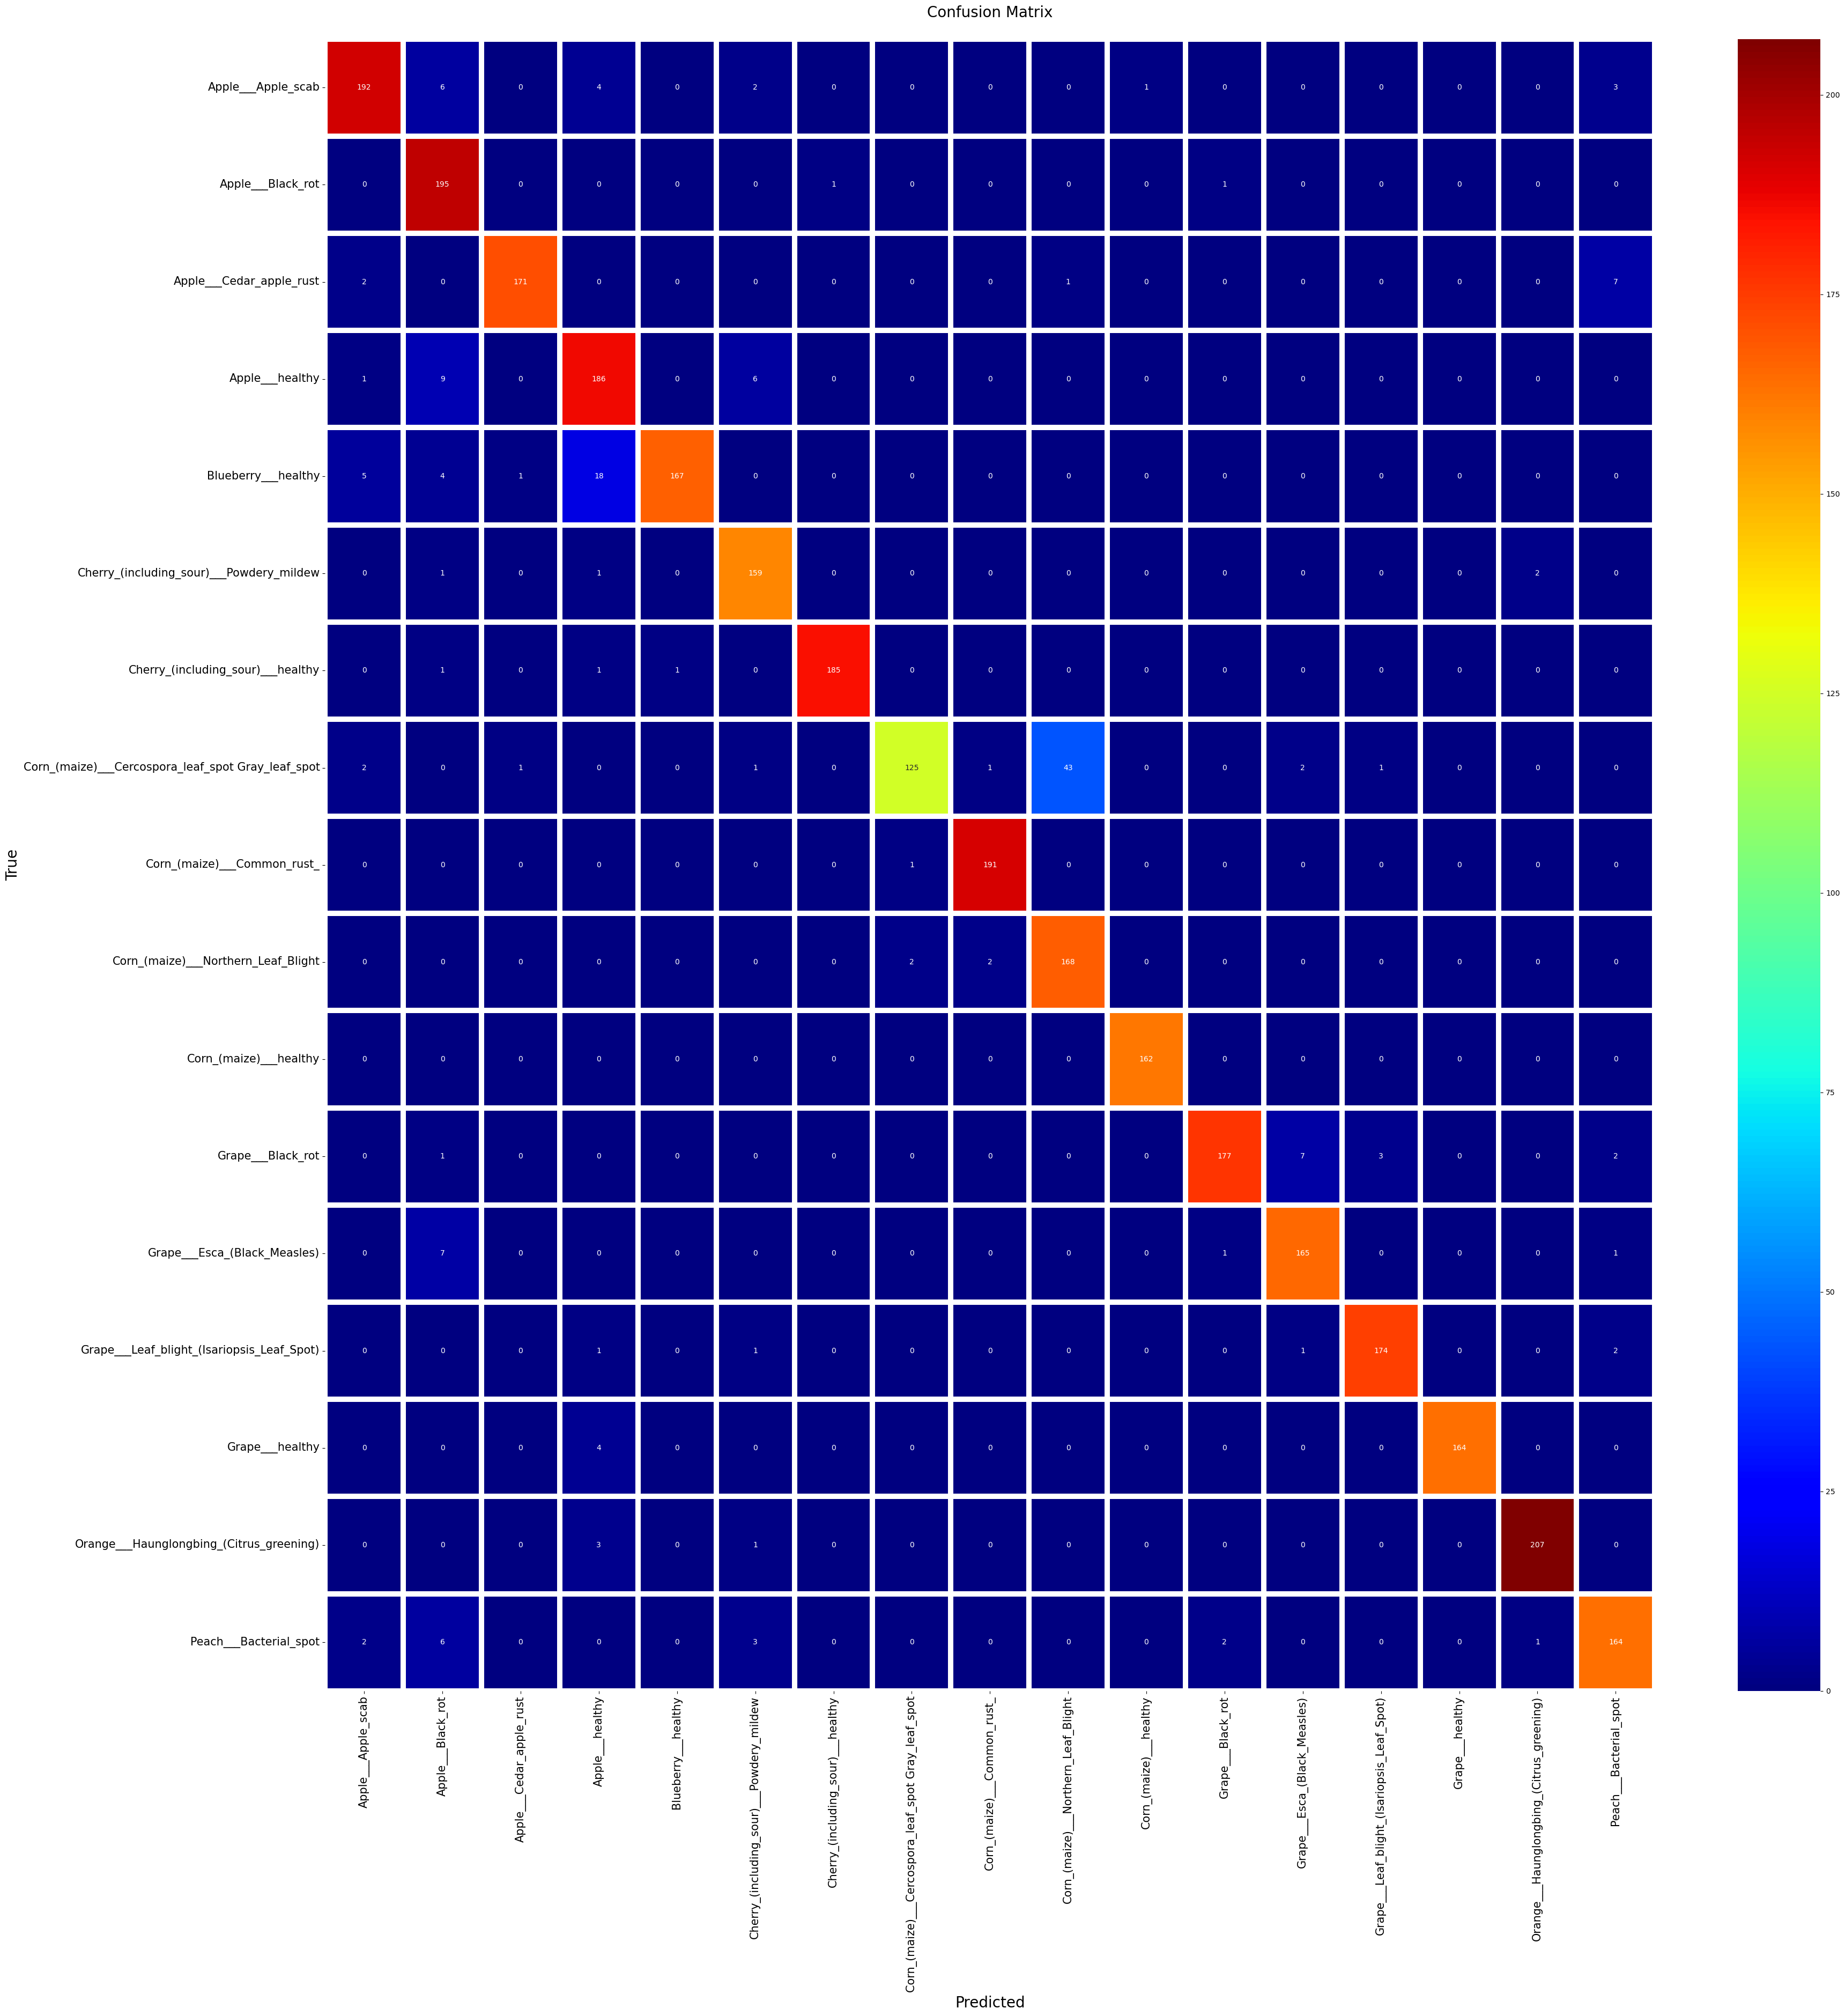

In [72]:
import seaborn as sns
plt.figure(figsize=(40,40))
confusion = confusion_matrix(labels, predictions)
sns.heatmap(confusion, annot=True, fmt='d', cmap='jet',xticklabels=class_names,
            yticklabels=class_names,lw=6)
plt.xlabel('Predicted',fontsize=20,color="black")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('True',fontsize=20,color="black")
plt.title('Confusion Matrix\n',fontsize=20,color="black")
plt.show()

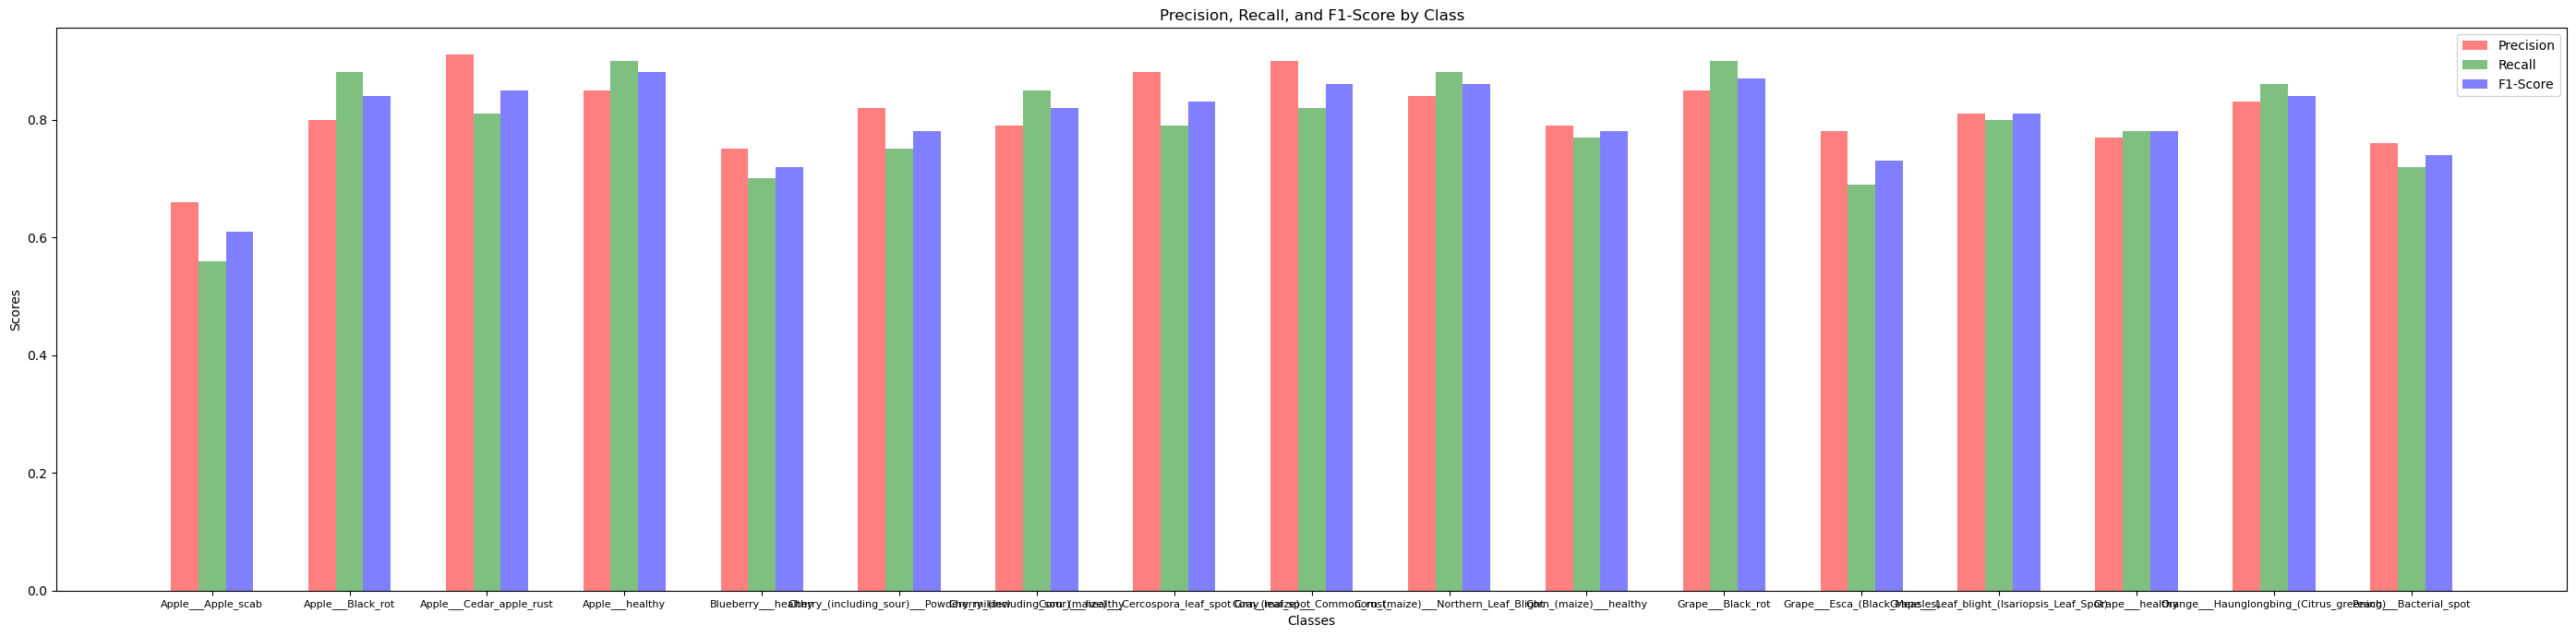

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
score_list = ["roc_auc", "accuracy", "f1", "precision", "recall"]
precision = [0.66, 0.80, 0.91, 0.85, 0.75, 0.82, 0.79, 0.88, 0.90, 0.84, 0.79, 0.85, 0.78, 0.81, 0.77, 0.83, 0.76]
recall = [0.56, 0.88, 0.81, 0.90, 0.70, 0.75, 0.85, 0.79, 0.82, 0.88, 0.77, 0.90, 0.69, 0.80, 0.78, 0.86, 0.72]
f1_score = [0.61, 0.84, 0.85, 0.88, 0.72, 0.78, 0.82, 0.83, 0.86, 0.86, 0.78, 0.87, 0.73, 0.81, 0.78, 0.84, 0.74]

# Ensure all arrays have the same length
num_classes = len(class_names)
index = np.arange(num_classes)
bar_width = 0.2

fig, ax = plt.subplots(figsize=(28, 7))

# Plotting the data
plt.bar(index, precision, bar_width, label='Precision', alpha=0.5, color='r')
plt.bar(index + bar_width, recall, bar_width, label='Recall', alpha=0.5, color='g')
plt.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-Score', alpha=0.5, color='b')

# Set x-axis label
plt.xlabel('Classes')
plt.xticks(fontsize=8)
plt.xticks([i + bar_width for i in index], class_names)

# Set y-axis label
plt.ylabel('Scores')

# Set the title of the plot
plt.title('Precision, Recall, and F1-Score by Class')

# Add a legend
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 58ms/step


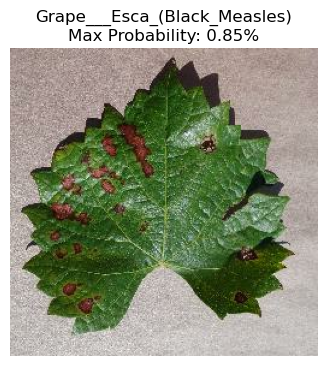

1/1 [==============================] - 0s 110ms/step


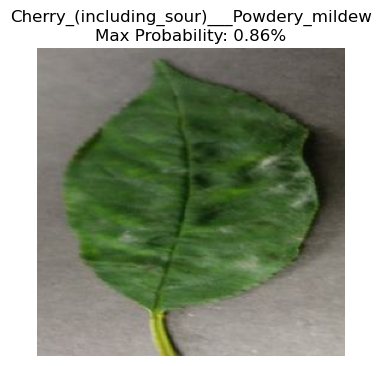

1/1 [==============================] - 0s 75ms/step


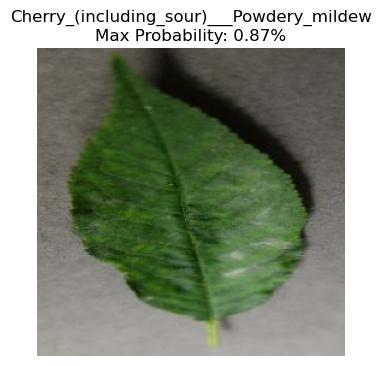

1/1 [==============================] - 0s 74ms/step


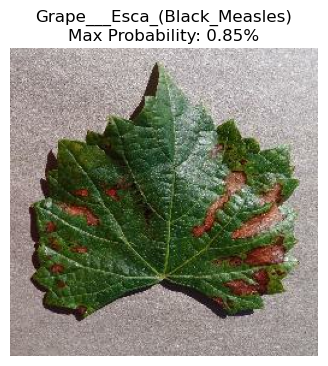

1/1 [==============================] - 0s 104ms/step


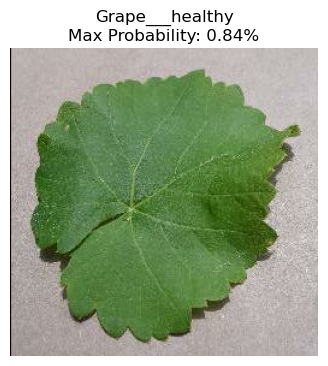

1/1 [==============================] - 0s 90ms/step


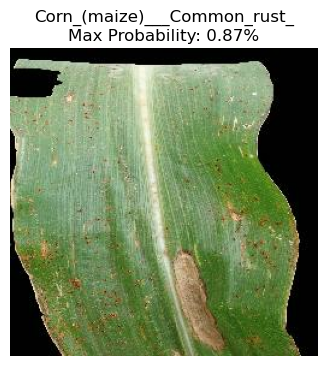

1/1 [==============================] - 0s 63ms/step


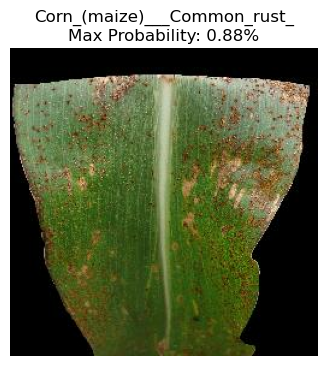

1/1 [==============================] - 0s 40ms/step


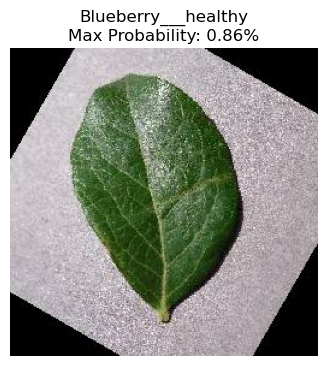

1/1 [==============================] - 0s 96ms/step


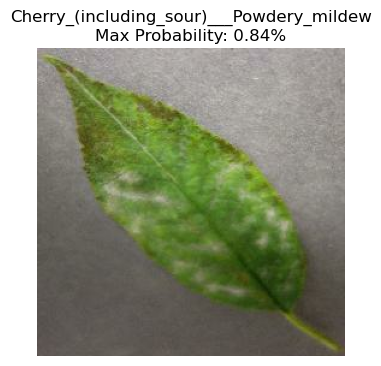

1/1 [==============================] - 0s 69ms/step


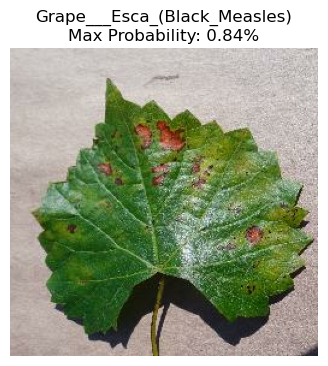

1/1 [==============================] - 0s 73ms/step


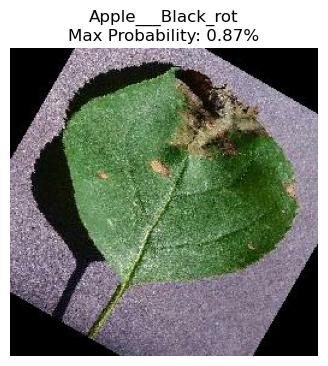

1/1 [==============================] - 0s 45ms/step


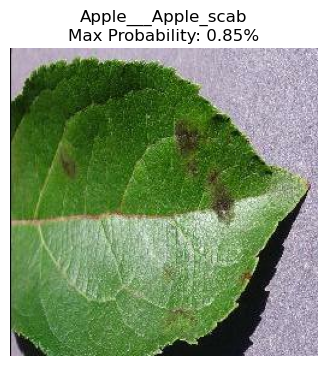

1/1 [==============================] - 0s 39ms/step


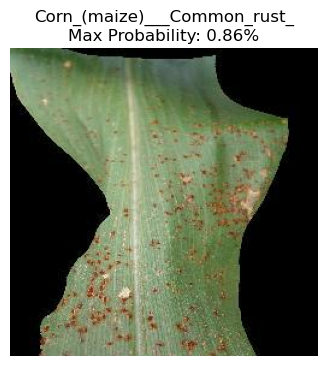

1/1 [==============================] - 0s 43ms/step


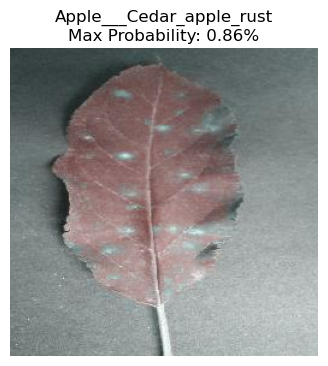

1/1 [==============================] - 0s 38ms/step


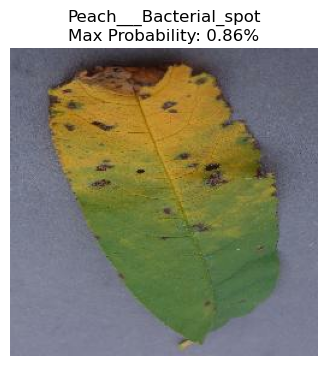

1/1 [==============================] - 0s 48ms/step


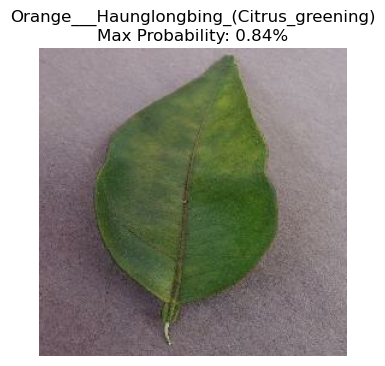

1/1 [==============================] - 0s 36ms/step


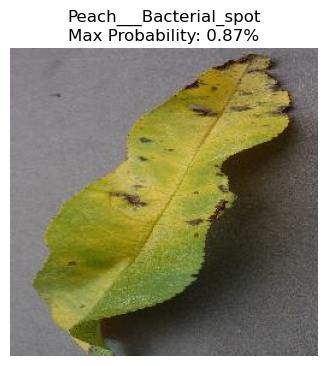

1/1 [==============================] - 0s 37ms/step


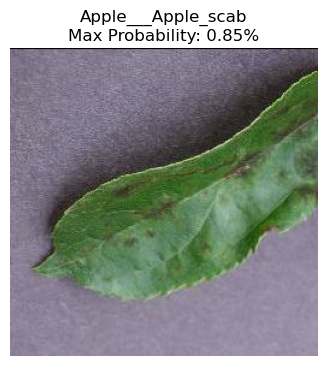

1/1 [==============================] - 0s 57ms/step


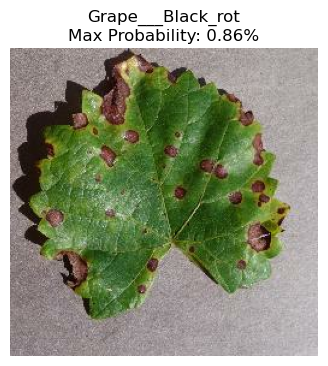

1/1 [==============================] - 0s 43ms/step


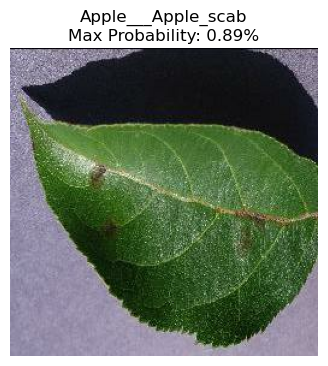

In [79]:
# predicting an image
import os
import matplotlib.pyplot as plt
import keras.utils
from keras.preprocessing import image
import numpy as np
for image_batch, label_batch in dataset.take(1):
     for i in range(20):
            img = image_batch[i].numpy().astype("uint8")
            img = np.expand_dims(img, axis=0)
            img = img/255
            prediction = model.predict(img)
            probabilty = prediction.flatten()
            max_prob = probabilty.max()
            index=prediction.argmax(axis=-1)[0]
            #ploting image with predicted class name        
            plt.figure(figsize = (4,4))
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.axis('off')
            #plt.title(class_name+" "+ str(max_prob)[0:4]+"%")
            plt.title(class_names[label_batch[i]] +"\n"+"Max Probability: " +str(max_prob)[0:4]+"%")
            plt.show()

In [81]:
model.save("plant_disease_model.keras")

In [82]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpjwad5d7b\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpjwad5d7b\assets


In [83]:
# Save the TensorFlow Lite model to a file
with open("plant_disease_model.tflite", "wb") as f:
    f.write(tflite_model)